In [1]:
k = 'HX_dr'

In [ ]:
k.startswith()

In [1]:
import tensorflow as tf
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# from argparse import ArgumentParser
# from configparser import ConfigParser
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense#, AlphaDropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from keras.constraints import max_norm
from keras.utils.generic_utils import get_custom_objects
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import compat
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress Keras/TF warnings
compat.v1.logging.set_verbosity(compat.v1.logging.ERROR) # suppress Keras/TF warnings

In [2]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

In [3]:
# from utils.analysis.tree import Tree
# bkg = Tree(get_qcd_ttbar('dnn'))

In [4]:
tree = Signal('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_1M/ntuple.root')

/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400_1M/ntuple.root


In [101]:
tree.nevents

569341

In [5]:
n_maxbtag = ak.sum(tree.jet_signalId[ak.argsort(tree.jet_btag, axis=1, ascending=False)][:,:6] > -1, axis=1)
n_in_event = ak.sum(ak.sort(tree.jet_signalId, axis=1, ascending=False)[:,:6] > -1, axis=1)

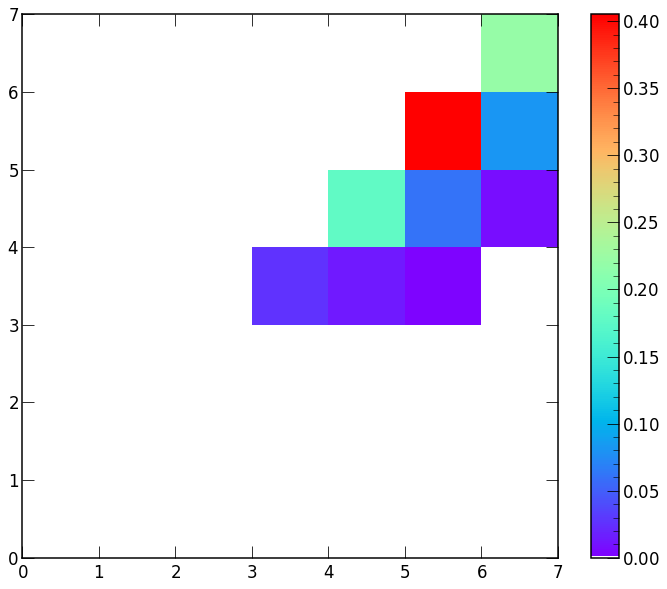

In [6]:
fig, ax = plt.subplots(figsize=(12,10))

n, ex, ey, im = Hist2d(n_in_event, n_maxbtag, bins=np.arange(8), ax=ax, density=1)

fig.colorbar(im, ax=ax)
ax.minorticks_off()

In [7]:
id_sort = ak.argsort(tree.jet_signalId, axis=1, ascending=False)[:,:6]
tree.jet_signalId[id_sort]
n_sigid_sort = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1)
n_sigid_sort

<Array [6, 5, 5, 4, 4, 5, ... 5, 5, 5, 5, 6, 5] type='569341 * int64'>

In [8]:
id_sort = ak.argsort(tree.jet_btag, axis=1, ascending=False)[:,:6]
n_btag_sort = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1)
tree.jet_signalId[id_sort], tree.jet_btag[id_sort],

(<Array [[3, 2, 0, 4, 5, 1, ... 1, 2, 4, 3, -1]] type='569341 * var * int32'>,
 <Array [[0.999, 0.999, ... 0.731, 0.0296]] type='569341 * var * float32'>)

In [102]:
n_sigid_sort, n_btag_sort, n_in_event

(<Array [6, 5, 5, 4, 4, 5, ... 5, 5, 5, 5, 6, 5] type='569341 * int64'>,
 <Array [6, 4, 5, 4, 4, 4, ... 4, 5, 5, 5, 6, 5] type='569341 * int64'>,
 <Array [6, 5, 5, 4, 4, 5, ... 5, 5, 5, 5, 6, 5] type='569341 * int64'>)

In [103]:
ak.sum(n_sigid_sort == 6), ak.sum(n_btag_sort), ak.sum(n_in_event)

(176884, 2779109, 2880221)

In [10]:
ak.sum(n_sigid_sort == 6), ak.sum(n_btag_sort == 6), ak.all(n_sigid_sort == n_btag_sort)

(176884, 126140, False)

In [11]:
sixb_event = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1) == 6
combinatoric_event = ak.sum(tree.jet_signalId[id_sort] > -1, axis=1) != 6

assert not ak.any(sixb_event == combinatoric_event)

n_sixb = ak.sum(sixb_event)

combinatoric_event = ak.local_index(tree.n_jet)[combinatoric_event][:n_sixb]
sixb_event = ak.local_index(tree.n_jet)[sixb_event]

In [12]:
sixb_event, combinatoric_event

(<Array [0, 6, 7, ... 569331, 569334, 569339] type='126140 * int64'>,
 <Array [1, 2, 3, 4, ... 162493, 162494, 162495] type='126140 * int64'>)

In [13]:
from itertools import combinations

In [14]:
combos = list(combinations(np.arange(6),2))
N = len(combos)

indices = []
for i,combo1 in enumerate(combos):
    combo1 = np.array(combo1)
    for j in range(i+1, N):
        combo2 = np.array(combos[j])
        # print(combo,combos[j])
        if combo1[0] in combo2 or combo1[1] in combo2: continue
        for k in range(j+1, N):
            combo3 = np.array(combos[k])
            if combo2[0] in combo3 or combo2[1] in combo3: continue
            if combo1[0] in combo3 or combo1[1] in combo3: continue
            indices.append(np.concatenate((combo1, combo2, combo3)))
        # break
    # break
indices = np.row_stack([ind for ind in indices])
indices

array([[0, 1, 2, 3, 4, 5],
       [0, 1, 2, 4, 3, 5],
       [0, 1, 2, 5, 3, 4],
       [0, 2, 1, 3, 4, 5],
       [0, 2, 1, 4, 3, 5],
       [0, 2, 1, 5, 3, 4],
       [0, 3, 1, 2, 4, 5],
       [0, 3, 1, 4, 2, 5],
       [0, 3, 1, 5, 2, 4],
       [0, 4, 1, 2, 3, 5],
       [0, 4, 1, 3, 2, 5],
       [0, 4, 1, 5, 2, 3],
       [0, 5, 1, 2, 3, 4],
       [0, 5, 1, 3, 2, 4],
       [0, 5, 1, 4, 2, 3]])

In [72]:
def get_min_dR(ttree, mask, sort_id):
    dR_dict = {}
    for i,j in combos:
        particle1 = Particle(kin_dict={
            'pt' : ttree.jet_ptRegressed[sort_id][mask][:,i],
            'eta' : ttree.jet_eta[sort_id][mask][:,i],
            'phi' : ttree.jet_phi[sort_id][mask][:,i],
            'm' : ttree.jet_mRegressed[sort_id][mask][:,i]
            })
        particle1.set_btag(ttree.jet_btag[sort_id][mask][:,i])
        
        particle2 = Particle(kin_dict={
            'pt' : ttree.jet_ptRegressed[sort_id][mask][:,j],
            'eta' : ttree.jet_eta[sort_id][mask][:,j],
            'phi' : ttree.jet_phi[sort_id][mask][:,j],
            'm' : ttree.jet_mRegressed[sort_id][mask][:,j]
            })
        particle2.set_btag(ttree.jet_btag[sort_id][mask][:,j])
        
        dR_dict[f"{i}{j}"] = particle1.deltaR(particle2)
    
    min_dR = np.column_stack([dR_dict[key].to_numpy() for key in dR_dict.keys()]).min(axis=1)
    max_dR = np.column_stack([dR_dict[key].to_numpy() for key in dR_dict.keys()]).max(axis=1)
    return min_dR, max_dR

In [16]:
def get_pair_kin(ttree, mask, sort_id):
    dPhi = []
    dEta = []
    for i,j in combos:
        particle1 = Particle(kin_dict={
            'pt' : ttree.jet_ptRegressed[sort_id][mask][:,i],
            'eta' : ttree.jet_eta[sort_id][mask][:,i],
            'phi' : ttree.jet_phi[sort_id][mask][:,i],
            'm' : ttree.jet_mRegressed[sort_id][mask][:,i]
            })
        
        particle2 = Particle(kin_dict={
            'pt' : ttree.jet_ptRegressed[sort_id][mask][:,j],
            'eta' : ttree.jet_eta[sort_id][mask][:,j],
            'phi' : ttree.jet_phi[sort_id][mask][:,j],
            'm' : ttree.jet_mRegressed[sort_id][mask][:,j]
            })
        
        dPhi.append(particle1.deltaPhi(particle2).to_numpy())
        dEta.append(particle1.deltaEta(particle2).to_numpy())
    
    dPhi = np.column_stack((np.array((dPhi))))
    dEta = np.column_stack((np.array((dEta))))
    # min_dR = np.column_stack([dR_dict[key].to_numpy() for key in dR_dict.keys()]).min(axis=1)
    return dPhi, dEta

In [73]:
min_dR_sixb, max_dR_sixb = get_min_dR(tree, sixb_event, id_sort)
min_dR_comb, max_dR_comb = get_min_dR(tree, combinatoric_event, id_sort)

In [18]:
min_dR_sixb

array([0.96852756, 0.49402815, 0.5518198 , ..., 0.72518146, 1.1474831 ,
       0.8472547 ], dtype=float32)

In [83]:
dPhi_sixb, dEta_sixb = get_pair_kin(tree, sixb_event, id_sort)
dPhi_comb, dEta_comb = get_pair_kin(tree, combinatoric_event, id_sort)

In [20]:
dPhi_sixb.shape

(126140, 15)

In [87]:
sixb_features = np.column_stack((
    tree.jet_ptRegressed[id_sort][sixb_event].to_numpy()[:,5],
    abs(tree.jet_eta[id_sort][sixb_event].to_numpy())[:,5],
    tree.jet_btag[id_sort][sixb_event].to_numpy()[:,5],
    min_dR_sixb,
    # dPhi_sixb,
    # dEta_sixb
))

sixb_labels = np.column_stack((np.ones(len(sixb_features)), np.zeros(len(sixb_features))))

comb_features = np.column_stack((
    tree.jet_ptRegressed[id_sort][combinatoric_event].to_numpy()[:,5],
    abs(tree.jet_eta[id_sort][combinatoric_event].to_numpy())[:,5],
    tree.jet_btag[id_sort][combinatoric_event].to_numpy()[:,5],
    min_dR_comb,
    # dPhi_comb,
    # dEta_comb
))
comb_labels = np.column_stack((np.zeros(len(comb_features)), np.ones(len(comb_features))))

features = np.row_stack((sixb_features, comb_features))
labels = np.row_stack((sixb_labels, comb_labels))

In [47]:
tree.jet_ptRegressed[id_sort][sixb_event][:,0]

<Array [61.5, 142, 131, ... 82.8, 185, 185] type='126140 * float32'>

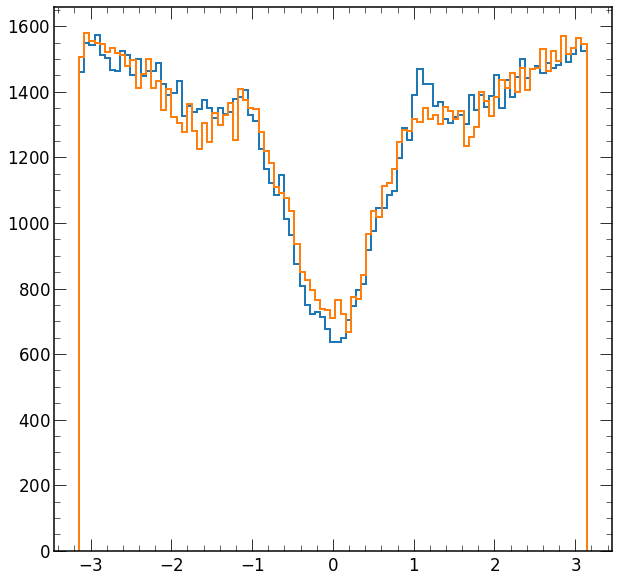

In [86]:
fig, ax = plt.subplots()

Hist(dPhi_sixb[:,5], bins=np.linspace(-3.14,3.14,100), ax=ax)
Hist(dPhi_comb[:,5], bins=np.linspace(-3.14,3.14,100), ax=ax)
plt.show()

In [33]:
labels.sum(axis=0)

array([126140., 126140.])

In [34]:
features.shape, labels.shape

((252280, 49), (252280, 2))

In [88]:
scaler = MinMaxScaler()
scaler.fit(features)
x = scaler.transform(features)

val_size = 0.10
x_train, x_val, y_train, y_val = train_test_split(x, labels, test_size=val_size)

param_dim = int(np.shape(features)[1])

In [77]:
param_dim

49

In [95]:
# Hidden hyperparameters
hidden_activations = 'selu'
nodes              = [40,40]
nlayers            = len(nodes)

# Output hyperparameters
output_activation  = 'softmax'
output_nodes       = 2

optimizer_name     = 'nadam'
loss_function      = 'binary_crossentropy'
nepochs            = 50
batch_size         = 200

met = ['accuracy']

lr = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=lr, beta_1=beta1, beta_2=beta2, epsilon=epsilon, name="Nadam")

es = EarlyStopping(monitor='loss', restore_best_weights=True, patience=10)

In [96]:
model = Sequential()

model.add(Dense(nodes[0], input_dim=param_dim, activation=hidden_activations))
for i in range(1,nlayers):
    model.add(Dense(int(nodes[i]), activation=hidden_activations, kernel_constraint=max_norm(1.0), kernel_regularizer=l1_l2(), bias_constraint=max_norm(1.0)))
    # model.add(Dense(int(nodes[i]), kernel_initializer='lecun_normal', activation=hidden_activations, kernel_constraint=max_norm(1.0), kernel_regularizer=l1_l2(), bias_constraint=max_norm(1.0)))
    # if bool(args.dropout): model.add(AlphaDropout(0.2)) 
model.add(Dense(output_nodes, activation=output_activation))

In [97]:
model.compile(
    loss=loss_function, 
    optimizer=optimizer, 
    metrics=met)

In [98]:
nn_info_list = [
    f"Input parameters:            {param_dim}\n",
    f"Optimizer:                   {optimizer}\n",
    f"Learning Rate:               {lr}\n",
    f"beta_1:                      {beta1}\n",
    f"beta_2:                      {beta2}\n",
    f"epsilon:                     {epsilon}\n",
    f"Loss:                        {loss_function}\n",
    f"Num epochs:                  {nepochs}\n",
    f"Batch size:                  {batch_size}\n",
    f"Num hidden layers:           {nlayers}\n",
    f"Input activation function:   {hidden_activations}\n",
    f"Hidden layer nodes:          {nodes}\n",
    f"Hidden activation functions: {hidden_activations}\n",
    f"Num output nodes:            {output_nodes}\n",
    f"Output activation function:  {output_activation.capitalize()}\n"]

for line in nn_info_list:
    print(line[:-1])

Input parameters:            4
Optimizer:                   <keras.optimizers.optimizer_v2.nadam.Nadam object at 0x7f73525cbe20>
Learning Rate:               0.001
beta_1:                      0.9
beta_2:                      0.999
epsilon:                     1e-07
Loss:                        binary_crossentropy
Num epochs:                  50
Batch size:                  200
Num hidden layers:           2
Input activation function:   selu
Hidden layer nodes:          [40, 40]
Hidden activation functions: selu
Num output nodes:            2
Output activation function:  Softmax


In [99]:
tf.config.run_functions_eagerly(True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized

In [100]:
history = model.fit(x_train,
                    y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=nepochs, 
                    batch_size=batch_size, 
                    callbacks=[es])

model.summary()

Epoch 1/50
1136/1136 [==============================] - 28s 25ms/step - loss: 0.8309 - accuracy: 0.7137 - val_loss: 0.5895 - val_accuracy: 0.7345
Epoch 2/50
1136/1136 [==============================] - 29s 25ms/step - loss: 0.5800 - accuracy: 0.7311 - val_loss: 0.5720 - val_accuracy: 0.7338
Epoch 3/50
1136/1136 [==============================] - 31s 27ms/step - loss: 0.5691 - accuracy: 0.7338 - val_loss: 0.5633 - val_accuracy: 0.7358
Epoch 4/50
1136/1136 [==============================] - 33s 29ms/step - loss: 0.5624 - accuracy: 0.7367 - val_loss: 0.5585 - val_accuracy: 0.7372
Epoch 5/50
1136/1136 [==============================] - 28s 25ms/step - loss: 0.5582 - accuracy: 0.7380 - val_loss: 0.5542 - val_accuracy: 0.7394
Epoch 6/50
1136/1136 [==============================] - 31s 27ms/step - loss: 0.5552 - accuracy: 0.7390 - val_loss: 0.5519 - val_accuracy: 0.7425
Epoch 7/50
1049/1136 [==========================>...] - ETA: 2s - loss: 0.5536 - accuracy: 0.7397

KeyboardInterrupt: 

In [ ]:
hist_df = DataFrame(history.history)

In [ ]:
out_dir = "ml/dnn_evt_sel"
h5_save   = f"{out_dir}/model.h5"
model.save_weights(h5_save)
model.save(f"{out_dir}/model")

In [48]:
from utils.modelUtils.save import ModelSaver

list

In [ ]:
ModelSaver(out_dir, model, history)

In [67]:
test_tree.jet_pt

<Array [[141, 134, 114, ... 121, 45.6, 89.6]] type='55952 * var * float32'>

In [79]:
model = load_model('ml/dnn_evt_sel')

OSError: SavedModel file does not exist at: ml/dnn_evt_sel/{saved_model.pbtxt|saved_model.pb}

In [22]:
test_tree = Signal('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root')

/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/cutflow_studies/presel/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root


In [ ]:
btag_sort = ak.argsort(test_tree.jet_btag, axis=1, ascending=False)

<Array [3, 0, 1, 4, 2, 5] type='6 * int64'>

In [36]:
test_dPhi, test_dEta = get_pair_kin(test_tree, mask=ak.local_index(test_tree.jet_pt)[:,:6], sort_id=ak.local_index(test_tree.jet_pt)[:,:6])

In [46]:
test_features = np.column_stack((
    test_tree.jet_ptRegressed[:,:6].to_numpy(),
    test_tree.jet_eta[:,:6].to_numpy(),
    get_min_dR(test_tree, mask=ak.local_index(test_tree.jet_pt)[:,:6], sort_id=ak.local_index(test_tree.jet_pt)[:,:6]),
    test_dPhi,
    test_dEta
))

In [48]:
scores = model.predict(test_features)[:,0]

1749/1749 [==============================] - 9s 5ms/step


In [68]:
scores.sum()/len(scores)

0.8467045413926223

In [54]:
test_hjet_mask = test_tree.jet_signalId > -1
event_mask = (ak.sum(test_hjet_mask, axis=1) == 6).to_numpy()*1

In [71]:
(scores == event_mask).sum()/len(scores)

0.3492279096368316

In [76]:
np.sum((scores > 0) & (scores < 1))

1945

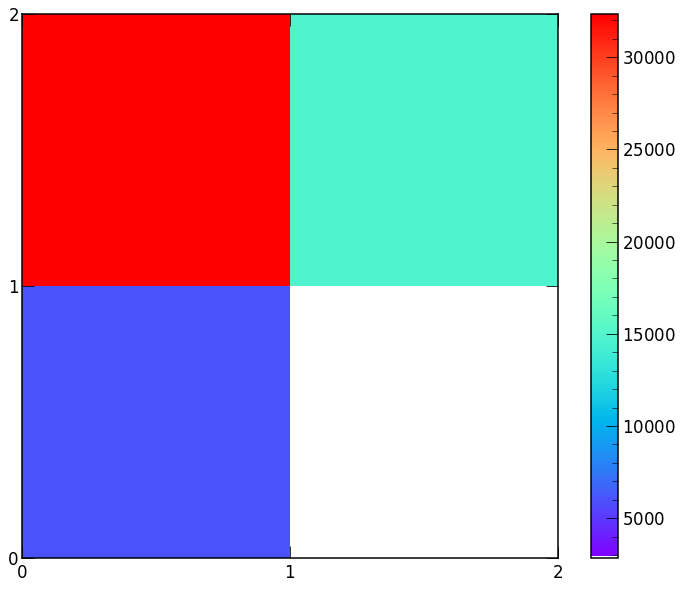

In [64]:
fig, ax = plt.subplots(figsize=(12,10))

n, ex, ey, im = Hist2d(event_mask, scores, bins=np.arange(3), ax=ax)
fig.colorbar(im, ax=ax)

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

ax.minorticks_off()

In [68]:
six_jet_mask = ak.local_index(test_tree.jet_pt)[:,:6]

In [73]:
min_dR_test = get_min_dR(test_tree, all_mask, six_jet_mask)
dPhi_test, dEta_test = get_pair_kin(test_tree, all_mask, six_jet_mask)

test_features = np.column_stack((
    test_tree.jet_ptRegressed.to_numpy(),
    test_tree.jet_eta.to_numpy(),
    min_dR_test,
    dPhi_test,
    dEta_test
))

ValueError: cannot fit jagged slice with length 569341 into RegularArray of size 55952

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/RegularArray.cpp#L1533)

In [ ]:
X = scaler.transform(features)